# Physics-informed neural network (PINN) demo


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the boundary conditions of the system
- Outputs: estimate of the solution, $y(x)$

#### Differential Equation with B.C.

$$ \frac{dy}{dx} + (1+x)\frac{d^2y}{dx^2}  = 0 $$

$$ y(0) = 0 $$

$$ y(1) = 1 $$





#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(x;\theta) \approx y(x)~,
$$


#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= \lambda_1(N\!N(0;\theta) - 0)^2 +  \frac{\lambda_2}{N} \sum^{N}_{i} \left( \frac{dN\!N(t_{i};\theta)}{dx} - x \right)^2
$$

#### Computing gradients

To compute gradients of the neural network with respect to its inputs, we will use `torch.autograd.grad`

## Initial setup

First, we define a few helper functions.

In [2]:
def exact_solution(x):
    u = (np.log(x+1))/np.log(2)
    return u

class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

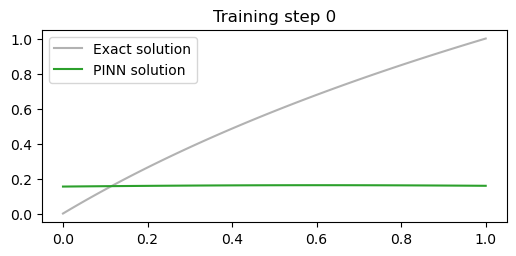

Epoch [1/6000], Loss: 0.5348
BC1 LOSS 0.022723732516169548
BC2 LOSS 0.7299802899360657
PDE LOSS 0.0037181018851697445


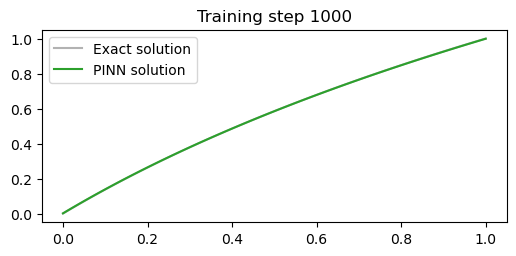

Epoch [1001/6000], Loss: 0.0002
BC1 LOSS 1.3274675438879058e-06
BC2 LOSS 1.4341894711833447e-06
PDE LOSS 0.0001654854859225452


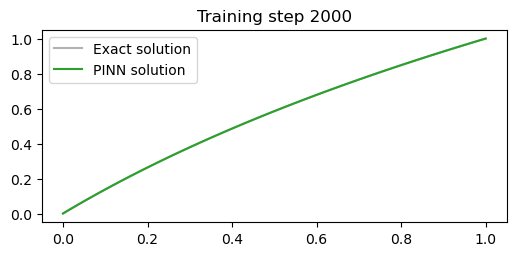

Epoch [2001/6000], Loss: 0.0000
BC1 LOSS 4.257931252027447e-08
BC2 LOSS 3.091749078976136e-08
PDE LOSS 5.495665755006485e-05


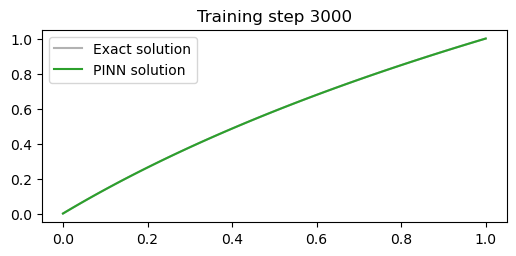

Epoch [3001/6000], Loss: 0.0000
BC1 LOSS 1.1226400253860902e-08
BC2 LOSS 1.1574829983374002e-08
PDE LOSS 3.4119952033506706e-05


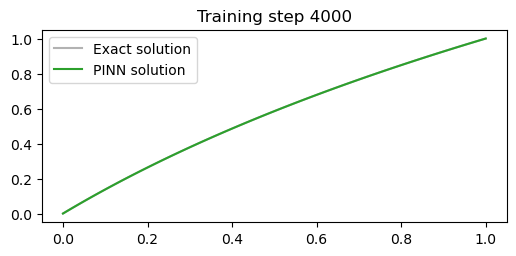

Epoch [4001/6000], Loss: 0.0000
BC1 LOSS 4.113246632186929e-09
BC2 LOSS 4.625210436870475e-09
PDE LOSS 2.1618257960653864e-05


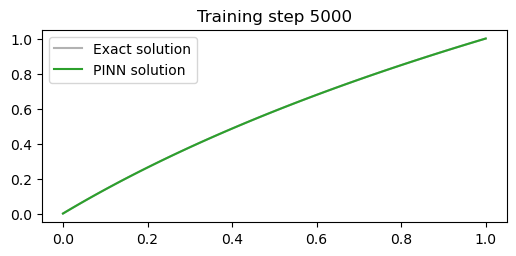

Epoch [5001/6000], Loss: 0.0000
BC1 LOSS 1.4120311586651724e-09
BC2 LOSS 1.6865477903138526e-09
PDE LOSS 1.2847209291066974e-05


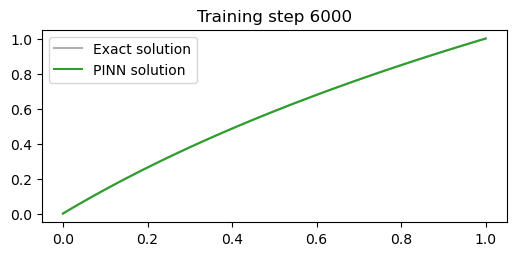

Epoch [6001/6000], Loss: 0.0000
BC1 LOSS 4.3598491483720636e-10
BC2 LOSS 5.293401272865594e-10
PDE LOSS 7.0130940912349615e-06


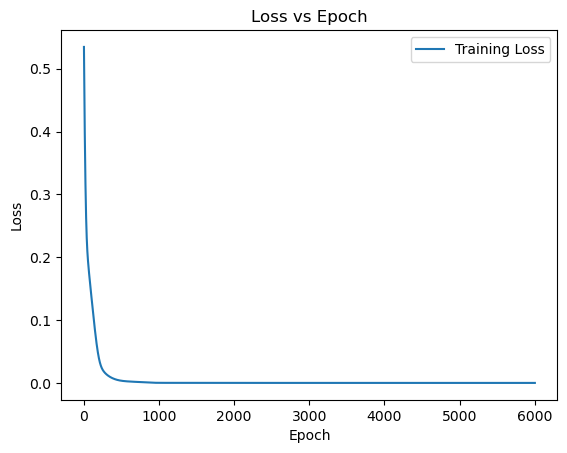

In [3]:
# define a neural network to train
pinn = FCN(1, 1, 64, 3)

# define boundary points, for the boundary loss
x_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)# (1, 1)
x_boundary2 = torch.tensor(1.0).view(-1,1).requires_grad_(True)# (1, 1)

# define training points over the entire domain, for the physics loss
x_physics = torch.linspace(0, 1, 100).view(-1,1).requires_grad_(True)# (20, 1)

x_test = torch.linspace(0,1,100).view(-1,1) #(200, 1)

u_exact = exact_solution(x_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-4)
num_epochs = 6000
losses = []
for i in range(num_epochs+1):
    optimiser.zero_grad()

    # using the following hyperparameters
    lambda1, lambda2 = 0.9, 0.7

    # compute boundary loss
    u = pinn(x_boundary)# (1, 1)
    loss1 = (torch.squeeze(u)-0)**2

    u2 = pinn(x_boundary2)
    # dudx = torch.autograd.grad(u2, x_boundary2, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    # dudx2 = torch.autograd.grad(dudx, x_boundary2, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    loss2 = (torch.squeeze(u2)-1)**2


    # compute physics loss
    u = pinn(x_physics)  # (20, 1)
    dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    dudx2 = torch.autograd.grad(dudx, x_physics, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    loss3 = torch.mean((dudx + (1+x_physics)*dudx2)**2)

    # backpropagate joint loss, take optimiser step
    loss = lambda1* loss1 + lambda2* loss2 + lambda1*loss3
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

    # plot the result as training progresses
    if i % 1000 == 0:
        u = pinn(x_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(x_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
        print(f"Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}")
        print(f'BC1 LOSS {loss1}')
        print(f'BC2 LOSS {loss2}')
        print(f'PDE LOSS {loss3}')


plt.plot(range(1, num_epochs+2), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

Avg Percentage Error is: 0.007216850761324167


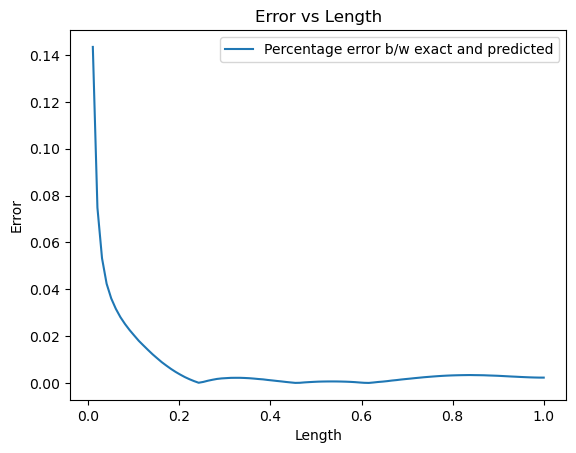

In [4]:
diff = abs(u_exact-u)/abs(0.01*u_exact)
print(f'Avg Percentage Error is: {torch.mean(diff[1:])}')
plt.plot(x_test, diff, label='Percentage error b/w exact and predicted')
plt.xlabel('Length')
plt.ylabel('Error')
plt.title('Error vs Length')
plt.legend()
plt.show()

Overall RMSE is: 1.805093779694289e-05


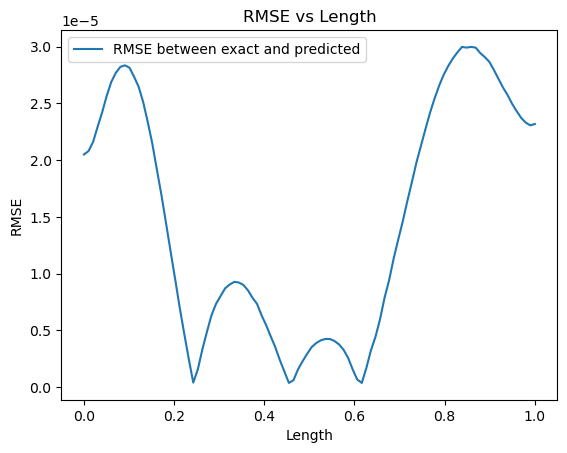

In [5]:
# Assuming u_exact and u are NumPy arrays
u_exact2 = u_exact.numpy()
u2 = u.numpy()

# Calculate RMSE at each point
rmse_per_point = np.sqrt(np.mean((u_exact2 - u2)**2, axis=1))
overall_rmse = np.sqrt(np.mean((u_exact2 - u2)**2))
print(f'Overall RMSE is: {overall_rmse}')

# Plot the RMSE at each point
plt.plot(x_test, rmse_per_point, label='RMSE between exact and predicted')
plt.xlabel('Length')
plt.ylabel('RMSE')
plt.title('RMSE vs Length')
plt.legend()
plt.show()


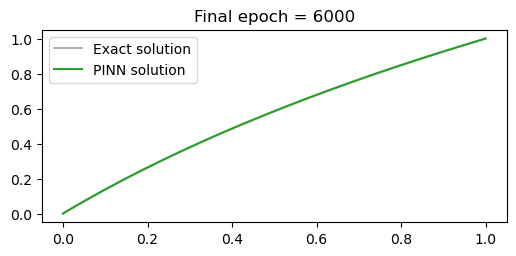

In [6]:
plt.figure(figsize=(6,2.5))
plt.plot(x_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
plt.title(f"Final epoch = {i}")
plt.legend()
plt.show()

In [7]:
print(u[-1])
print(u_exact[-1])

tensor([1.0000])
tensor([1.])


In [8]:
len(u)

100

In [9]:
print(u[99])

tensor([1.0000])
